In [69]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

In [70]:
# Load Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

In [71]:
# Data Cleaning
train['Sex_binary'] = train.Sex.map({"male": 0, "female": 1}) 
test['Sex_binary'] = test.Sex.map({"male": 0, "female": 1})

train['Age'] = train['Age'].fillna(round(train['Age'].mean()))
test['Age'] = test['Age'].fillna(round(test['Age'].mean()))
test['Fare'] = test['Fare'].fillna(round(test['Fare'].mean()))

columns_to_drop = ["PassengerId", "Name", "Sex",  "Ticket", "Cabin", "Embarked"]

train = train.drop(columns_to_drop, axis = 1)
test = test.drop(columns_to_drop, axis = 1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_binary
0,0,3,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,1
2,1,3,26.0,0,0,7.9250,1
3,1,1,35.0,1,0,53.1000,1
4,0,3,35.0,0,0,8.0500,0


In [72]:
# Assign Features and Labels
X_train = train[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_binary"]]
y_train = train["Survived"]
X_test = test[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_binary"]]
y_test = gender_submission["Survived"]

In [73]:
# Initialize Scaler Instance and Model from sklearn.impute import SimpleImputer

# Create the scaler
scaler = MinMaxScaler()

# Create the logistic regression model
lr_model = LogisticRegression()

In [74]:
pipeline = Pipeline([
    ('scaler', scaler),
    ('lr', lr_model)
])

In [75]:
# # Fit the pipeline to your training data 
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_test)

[0.8        0.78651685 0.78651685 0.82022472 0.79775281 0.76404494
 0.7752809  0.75280899 0.83146067 0.79775281]


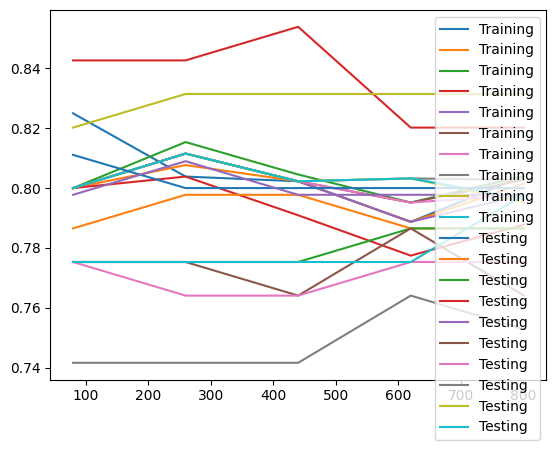

In [76]:
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt

# Cross-Validation Curve
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10)
print(cv_scores)  # Example output

# Learning Curve 
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=10)
plt.plot(train_sizes, train_scores, label='Training')
plt.plot(train_sizes, test_scores, label='Testing')
plt.legend()
plt.show()


In [79]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV 

# Hyperparameter Grid (adjust as needed)
param_grid = {
    'lr__penalty': ['l2'],
    'lr__C': [0.01, 0.1, 1, 10]
}

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, refit=True)
grid_search.fit(X_train, y_train)
# print(grid_search.best_params_) 

best_model = grid_search.best_estimator_
best_model.steps[-1][1].solver = 'liblinear'  # Or 'saga' 

# RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_grid, cv=5, n_iter=20) 
random_search.fit(X_train, y_train)
# print(random_search.best_params_)

# BayesSearchCV
bayes_search = BayesSearchCV(pipeline, param_grid, cv=5) 
bayes_search.fit(X_train, y_train) 
# print(bayes_search.best_params_) 


{'lr__C': 0.1, 'lr__penalty': 'l2'}
{'lr__penalty': 'l2', 'lr__C': 0.1}


c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 'l2'] before, using random point [0.01, 'l2']
  warnings.warn(
c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 'l2'] before, using random point [1, 'l2']
  warnings.warn(
c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 'l2'] before, using random point [0.01, 'l2']
  warnings.warn(
c:\Users\

OrderedDict({'lr__C': 0.1, 'lr__penalty': 'l2'})


In [80]:
print("grid_search.best_params_") 
print(grid_search.best_params_) 

print("random_search.best_params_")
print(random_search.best_params_)

print("bayes_search.best_params_") 
print(bayes_search.best_params_) 

grid_search.best_params_
{'lr__C': 0.1, 'lr__penalty': 'l2'}
random_search.best_params_
{'lr__penalty': 'l2', 'lr__C': 0.1}
bayes_search.best_params_
OrderedDict({'lr__C': 0.1, 'lr__penalty': 'l2'})


In [82]:
from hyperopt import fmin, tpe, hp

# Define the objective function (example)
def objective(params):
    pipeline.set_params(**params)  
    return -np.mean(cross_val_score(pipeline, X_train, y_train, cv=5)) 

# Define the search space 
space = {
    'lr__penalty': hp.choice('lr__penalty', ['l2']),
    'lr__C': hp.uniform('lr__C', 0.001, 10)
}

# Run TPE optimization
best = fmin(objective, space, algo=tpe.suggest, max_evals=50) 


100%|██████████| 50/50 [00:00<00:00, 61.80trial/s, best loss: -0.7890025735986441]
